In [1]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def run_cinema_ot(adata, condition_key, cell_type_key,exp_label,ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    print(adata_)
    sc.pp.pca(adata_)
    print(condition_key,ref_label,exp_label,cell_type_key)
    cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_, obs_label=condition_key, ref_label=ref_label,
                                                 expr_label=exp_label, mode='parametric', thres=0.5,
                                                 smoothness=1e-5, eps=1e-3, preweight_label=cell_type_key)
    de.write("./cinema_ot/"+dataset_name+"_ITE.h5ad")
    adata_.obsm['cf'] = cf.copy()
    adata_.obsm['cf'][adata_.obs[condition_key]==ref_label,:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs[condition_key]==exp_label,:])
    sc.pp.neighbors(adata_, use_rep='cf')

    sc.tl.umap(adata_, random_state=1)
    print("Effect modifier (called confounder in this paper) space:")
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    adata_.write("./cinema_ot/"+dataset_name+".h5ad")
    
    try:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")
    except:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
condition control stimulated cell_type
Effect modifier (called confounder in this paper) space:


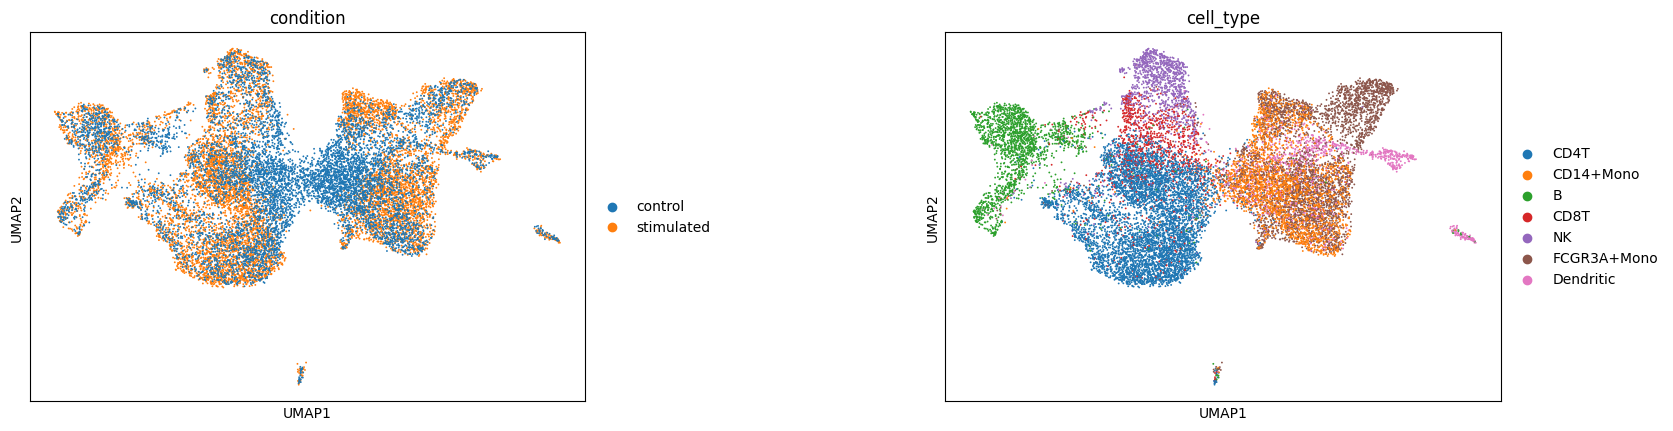

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9223846833768742 0.3338897666326589 0.4902986074036712
ASW---
asw_label 0.5142540391534567
asw_batch 0.7542731589750041
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 5
kbet_score 0.34153895174591675
graph_conn 0.9676977454741978
NMI, ARI ---
NMI 0.6219500170315231
ARI 0.537021481713828
positive and true positive rate---
    ASW_label       ARI      NMI   1-cLISI    bLISI  ASW_batch  \
cf   0.514254  0.537021  0.62195  0.922385  0.33389   0.754273   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.341539            0.967

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_cinema_ot(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'dis

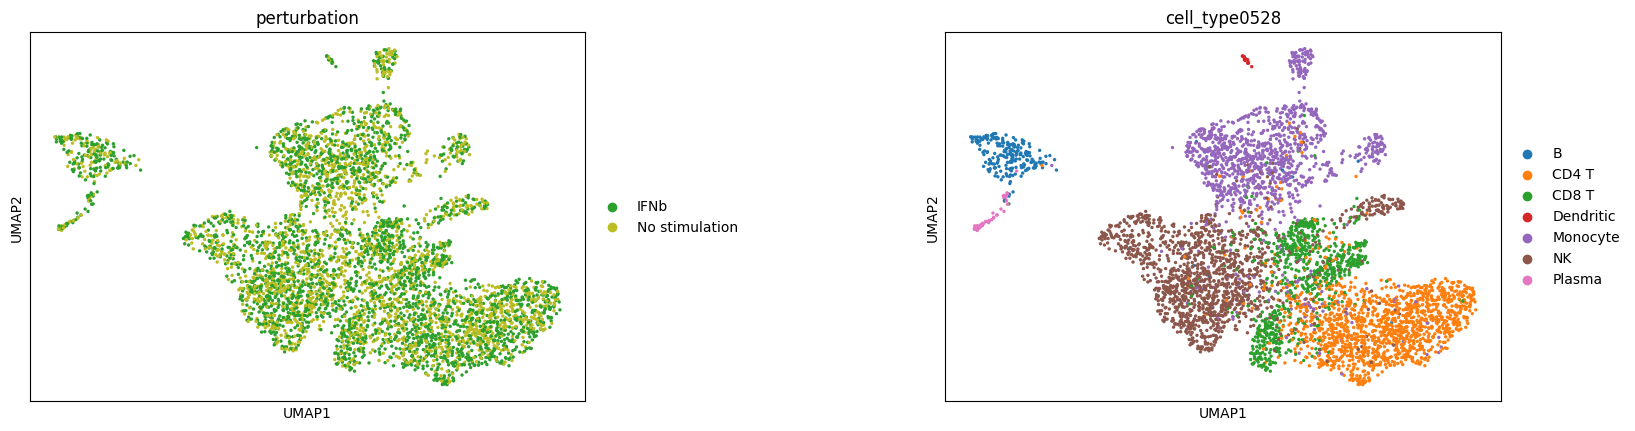

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /home/xx244/.conda/envs/benchmark/lib/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9450874688606211 0.5596354106162651 0.7029924525211884
ASW---
asw_label 0.5302715972065926
asw_batch 0.8560919048337319
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
kbet_score 0.8063051100093241
graph_conn 0.9931465330257189
NMI, ARI ---
NMI 0.6079441911194499
ARI 0.5849053564763463
positive and true positive rate---
    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.530272  0.584905  0.607944  0.945087  0.559635   0.856092   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.806305            0.993147   0.998609  0.889397       0.632584   

     F1 LISI  
cf  0.702992  


In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_cinema_ot(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
condition MOCK CSE cell_type1021
Effect modifier (called confounder in this paper) space:


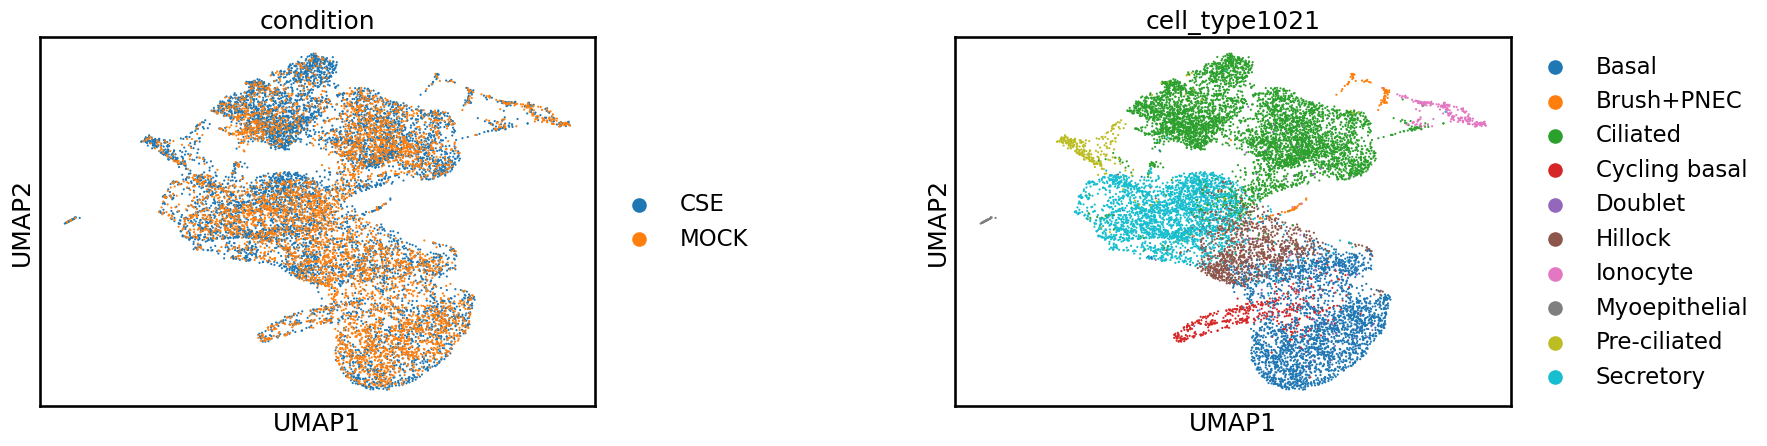

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
LISI---
cLISI, bLISI, LISI_F1 0.9826961179821365 0.47228548040208684 0.6379642308684357
ASW---
asw_label 0.5108740171417594
asw_batch 0.8362897907775281
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
kbet_score 0.6555076634924624
graph_conn 0.9701668043807887
NMI, ARI ---
NMI 0.6866809853566518
ARI 0.569563095038004
positive and true positive rate---


In [ ]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_cinema_ot(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

In [ ]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_cinema_ot(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

In [ ]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_cinema_ot(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")